In [42]:
from pathlib import Path
import requests

wiki_titles = [
    "Cowboy Bebop",
    "Aurora",
    "Orchid",
    "The Tor Project",
]

data_path = Path("data_wiki")

for title in wiki_titles:
    response = requests.get(
        "https://en.wikipedia.org/w/api.php",
        params={
            "action": "query",
            "prop": "extracts",
            "format": "json",
            "titles": title,
            "explaintext": True,
        },
    ).json()
    page = next(iter(response["query"]["pages"].values()))
    wiki_text = page["extract"]

    if not data_path.exists():
        Path.mkdir(data_path)

    with open(data_path / f"{title}.txt", "w") as fp:
        fp.write(wiki_text)

In [43]:
import requests
from pathlib import Path
import urllib.request

image_path = Path("data_wiki")
image_uuid = 0

image_metadata_dict = {}
MAX_IMAGES_PER_WIKI = 30

wiki_titles = [
    "Cowboy Bebop",
    "Aurora",
    "Orchid",
    "The Tor Project",
]

if not image_path.exists():
    Path.mkdir(image_path)

headers = {
    "User-Agent": "Wikipedia API Agent"
}

for title in wiki_titles:
    images_per_wiki = 0
    print(title)
    try:
        response = requests.get(
            "https://en.wikipedia.org/w/api.php",
            params={
                "action": "query",
                "titles": title,
                "prop": "images",
                "format": "json",
            },
            headers=headers
        ).json()
        
        pages = response["query"]["pages"]
        page = next(iter(pages.values()))
        if "images" not in page:
            raise Exception(f"No images found for Wikipedia page: {title}")
        
        list_img_urls = page["images"]
        for img in list_img_urls:
            img_title = img["title"]
            img_response = requests.get(
                "https://en.wikipedia.org/w/api.php",
                params={
                    "action": "query",
                    "titles": img_title,
                    "prop": "imageinfo",
                    "iiprop": "url",
                    "format": "json",
                },
                headers=headers
            ).json()
            
            img_pages = img_response["query"]["pages"]
            img_page = next(iter(img_pages.values()))
            if "imageinfo" not in img_page:
                continue
            
            img_url = img_page["imageinfo"][0]["url"]
            if img_url.endswith(".jpg") or img_url.endswith(".png"):
                image_uuid += 1
                image_file_name = title + "_" + img_url.split("/")[-1]

                image_metadata_dict[image_uuid] = {
                    "filename": image_file_name,
                    "img_path": "./" + str(image_path / f"{image_uuid}.jpg"),
                }
                urllib.request.urlretrieve(
                    img_url, image_path / f"{image_uuid}.jpg"
                )
                images_per_wiki += 1
                if images_per_wiki >= MAX_IMAGES_PER_WIKI:
                    break
    except Exception as e:
        print(f"No images found for Wikipedia page: {title}. Error: {e}")
        continue

Cowboy Bebop
Aurora
Orchid
The Tor Project


In [45]:
from dotenv import load_dotenv
import os
from openai import OpenAI

load_dotenv()

openai_api_key = os.getenv('OPENAI_API_KEY')

openai_client = OpenAI(api_key=openai_api_key)

In [46]:
import qdrant_client 
from llama_index.core import SimpleDirectoryReader
from llama_index.vector_stores.qdrant import QdrantVectorStore
from llama_index.core import VectorStoreIndex, StorageContext
from llama_index.core.indices import MultiModalVectorStoreIndex

client = qdrant_client.QdrantClient(path="qdrant_d_0")

text_store = QdrantVectorStore(
    client=client, collection_name="text_collection_0"
)
image_store = QdrantVectorStore(
    client=client, collection_name="image_collection_0"
)
storage_context = StorageContext.from_defaults(
    vector_store=text_store,
    image_store=image_store
)

documents = SimpleDirectoryReader("./data_wiki/").load_data()
index = MultiModalVectorStoreIndex.from_documents(
    documents,
    storage_context=storage_context,    
)

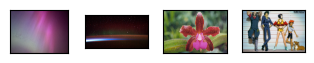

In [47]:
from PIL import Image
import matplotlib.pyplot as plt
import os

def plot_images(image_paths):
    images_shown = 0
    for img_path in image_paths:
        if os.path.isfile(img_path):
            image = Image.open(img_path).convert("RGB")

            plt.subplot(8, 8, images_shown + 1)
            plt.imshow(image)
            plt.xticks([])
            plt.yticks([])

            images_shown += 1
            if images_shown >= 64:
                break

    plt.tight_layout()

plot_images(retrieved_image)

In [49]:
test_query = "Who created Cowboy Bebop"

retriever = index.as_retriever(similarity_top_k=3, image_similarity_top_k=5)
retrieval_results = retriever.retrieve(test_query)

In [50]:
retrieval_results

[NodeWithScore(node=TextNode(id_='b91ca2b4-e35c-4456-958d-376e13befa7f', embedding=None, metadata={'file_path': '/home/gengar/data/graph/multiModalRAG/data_wiki/Cowboy Bebop.txt', 'file_name': 'Cowboy Bebop.txt', 'file_type': 'text/plain', 'file_size': 38752, 'creation_date': '2024-07-16', 'last_modified_date': '2024-07-16'}, excluded_embed_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], excluded_llm_metadata_keys=['file_name', 'file_type', 'file_size', 'creation_date', 'last_modified_date', 'last_accessed_date'], relationships={<NodeRelationship.SOURCE: '1'>: RelatedNodeInfo(node_id='b9dad6e4-7197-46af-a8e6-4ea276a15367', node_type=<ObjectType.DOCUMENT: '4'>, metadata={'file_path': '/home/gengar/data/graph/multiModalRAG/data_wiki/Cowboy Bebop.txt', 'file_name': 'Cowboy Bebop.txt', 'file_type': 'text/plain', 'file_size': 38752, 'creation_date': '2024-07-16', 'last_modified_date': '2024-07-16'}, hash='60d0edb5e9fdcc2436

**Node ID:** b91ca2b4-e35c-4456-958d-376e13befa7f<br>**Similarity:** 0.8744178717656217<br>**Text:** == Production ==

Cowboy Bebop was developed by animation studio Sunrise and created by Hajime Yatate, the well-known pseudonym for the collective contributions of Sunrise's animation staff. The le...<br>

**Node ID:** f3d4da96-3ee0-411e-a307-763766c68ce7<br>**Similarity:** 0.8576816783742275<br>**Text:** Cowboy Bebop (Japanese: カウボーイビバップ, Hepburn: Kaubōi Bibappu) is a Japanese neo-noir space Western anime television series which aired on TV Tokyo and Wowow from 1998 to 1999. It was created and anim...<br>

**Node ID:** 1c9017ac-1be7-4321-b039-5792bdd68453<br>**Similarity:** 0.8557113748266737<br>**Text:** === Development ===
The project had initially originated with Bandai's toy division as a sponsor, with the goal of selling spacecraft toys. Watanabe recalled his only instruction was "So long as th...<br>

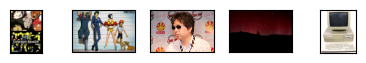

In [51]:
from llama_index.core.response.notebook_utils import display_source_node
from llama_index.core.schema import ImageNode


retrieved_image = []
for res_node in retrieval_results:
    if isinstance(res_node.node, ImageNode):
        retrieved_image.append(res_node.node.metadata["file_path"])
    else:
        display_source_node(res_node, source_length=200)

plot_images(retrieved_image)